# Descargar el Dataset de kaggle 
(No volver a descargar, ya está en la carpeta data/chestxray del proyecto)

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [05:58<00:00, 126MB/s] 

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


La celda de abajo mueve los archivos de la carpeta del cache de kagglehub a la carpeta del proyecto. 
En la instancia de Google Cloud los datos son persistentes, no es necesario bajarlos de GDrive.

In [9]:

from pathlib import Path
import shutil
from tqdm.notebook import tqdm

src = Path("/home/jupyter/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3")
dst = Path("./data/chestxray")

dst.mkdir(parents=True, exist_ok=True)

items = list(src.iterdir())
for p in tqdm(items, desc="Moviendo archivos"):
    target = dst / p.name
    try:
        # mover archivo o carpeta
        shutil.move(str(p), str(target))
    except Exception as e:
        print(f"Error moviendo {p}: {e}")


Moviendo archivos:   0%|          | 0/21 [00:00<?, ?it/s]

# imports necesarios y verificación de la carpeta con el dataset

In [55]:

from pathlib import Path
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


data_path = Path("./data/chestxray")


print("Data encontrada:", data_path.exists())

# Preparación Entorno

Esta celda carga las clases de python locales

In [57]:
code_dir = (Path.cwd() / "code").resolve()
print("code_dir:", code_dir)
if not code_dir.exists():
    raise FileNotFoundError(f"No existe la carpeta {code_dir}")

if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))
    print("Añadido a sys.path")

# listar archivos relevantes
for p in sorted(code_dir.iterdir()):
    print("-", p.name)
from genCSVMap import prepare_labels_dataset

code_dir: /home/jupyter/ProyectoCNN/code
- CNNTransformerFusion.py
- __pycache__
- datasetMgr.py
- genCSVMap.py


In [58]:
df = pd.read_csv(data_path / "Data_Entry_2017.csv")
print(df.head())

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [59]:
labels_df, train_val_df, test_df = prepare_labels_dataset(
    base_path='./data/chestxray'
)


One-hot encoding diseases: 100%|██████████| 14/14 [00:00<00:00, 59.63it/s]


Buscando imágenes en subcarpetas...
112120 imágenes encontradas en estructura de carpetas.
Dataset procesado guardado en: ./data/chestxray/IdxDataset.csv
Train/Val: 36024 imágenes
Test: 15735 imágenes

Ejemplo (primeras 5 filas):
        Image_Index                                               Path  \
0  00000001_000.png  ./data/chestxray/images_001/images/00000001_00...   
1  00000001_001.png  ./data/chestxray/images_001/images/00000001_00...   
2  00000001_002.png  ./data/chestxray/images_001/images/00000001_00...   
3  00000003_000.png  ./data/chestxray/images_001/images/00000003_00...   
4  00000003_001.png  ./data/chestxray/images_001/images/00000003_00...   

   Patient_Age  Gender_Code  View_Code  Atelectasis  Consolidation  \
0           58            1          1            0              0   
1           58            1          1            0              0   
2           58            1          1            0              0   
3           81            0          1       

In [30]:
labels_df

,Image_Index,Path,Patient_Age,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000003_000.png,./data/chestxray/images_001/images/00000003_00...,81,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,00000003_001.png,./data/chestxray/images_001/images/00000003_00...,74,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51754,00030786_007.png,./data/chestxray/images_012/images/00030786_00...,61,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
51755,00030789_000.png,./data/chestxray/images_012/images/00030789_00...,52,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
51756,00030793_000.png,./data/chestxray/images_012/images/00030793_00...,58,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
51757,00030795_000.png,./data/chestxray/images_012/images/00030795_00...,53,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [31]:
train_val_df

,Image_Index,Path,Patient_Age,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,./data/chestxray/images_001/images/00000001_00...,58,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000004_000.png,./data/chestxray/images_001/images/00000004_00...,82,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,00000005_006.png,./data/chestxray/images_001/images/00000005_00...,70,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36019,00030786_007.png,./data/chestxray/images_012/images/00030786_00...,61,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
36020,00030789_000.png,./data/chestxray/images_012/images/00030789_00...,52,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
36021,00030793_000.png,./data/chestxray/images_012/images/00030793_00...,58,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
36022,00030795_000.png,./data/chestxray/images_012/images/00030795_00...,53,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [32]:
test_df

,Image_Index,Path,Patient_Age,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000003_000.png,./data/chestxray/images_001/images/00000003_00...,81,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,00000003_001.png,./data/chestxray/images_001/images/00000003_00...,74,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,00000003_002.png,./data/chestxray/images_001/images/00000003_00...,75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000003_003.png,./data/chestxray/images_001/images/00000003_00...,76,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,00000003_004.png,./data/chestxray/images_001/images/00000003_00...,77,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15730,00030637_022.png,./data/chestxray/images_012/images/00030637_02...,49,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15731,00030637_023.png,./data/chestxray/images_012/images/00030637_02...,49,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15732,00030674_000.png,./data/chestxray/images_012/images/00030674_00...,80,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15733,00030677_000.png,./data/chestxray/images_012/images/00030677_00...,50,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [33]:
labels_df.columns

Index(['Image_Index', 'Path', 'Patient_Age', 'Gender_Code', 'View_Code',
       'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
       'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'],
      dtype='object')

In [60]:

train_df, val_df = train_test_split( train_val_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)} imágenes")
print(f"Val:   {len(val_df)} imágenes")
print(f"Test:  {len(test_df)} imágenes")

Train: 28819 imágenes
Val:   7205 imágenes
Test:  15735 imágenes


# Transforming

In [62]:
DISEASE_COLUMNS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

In [63]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [64]:
from datasetMgr import datasetMgr

In [65]:
train_dataset = datasetMgr(dataframe=train_df,disease_columns=DISEASE_COLUMNS,transform=train_transform)
val_dataset = datasetMgr(dataframe=val_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)
test_dataset = datasetMgr(dataframe=test_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)

In [66]:
print(f"Train dataset: {len(train_dataset)} muestras")
print(f"Val dataset:   {len(val_dataset)} muestras")
print(f"Test dataset:  {len(test_dataset)} muestras")


Train dataset: 28819 muestras
Val dataset:   7205 muestras
Test dataset:  15735 muestras


## Dataloader

In [67]:
BATCH_SIZE = 32

In [68]:
NUM_WORKERS = 8 # Con 8 funciona bien en GCloud, no he probado con más

In [69]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

### Dataloaders Creados

In [70]:
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

   Train batches: 901
   Val batches:   226
   Test batches:  492


In [71]:
images, meta, labels = next(iter(train_loader))

print(f"\nBatch de entrenamiento:")
print(f"Imágenes shape: {images.shape}")      # Debe ser (32, 3, 224, 224) para ser compatible por RESNET
print(f"Labels shape:   {labels.shape}")      # Debe ser (32, 14) IDEM
print(f"Imágenes - Min: {images.min():.3f}, Max: {images.max():.3f}")
print(f"Labels - Min:   {labels.min():.0f}, Max: {labels.max():.0f}")


print(f"\n  Labels por enfermedad en este batch:")
for i, disease in enumerate(DISEASE_COLUMNS):
    count = labels[:, i].sum().item()
    print(f"    {disease:20s}: {count:.0f}/{BATCH_SIZE}")


Batch de entrenamiento:
Imágenes shape: torch.Size([32, 3, 224, 224])
Labels shape:   torch.Size([32, 14])
Imágenes - Min: -2.118, Max: 2.640
Labels - Min:   0, Max: 1

  Labels por enfermedad en este batch:
    Atelectasis         : 8/32
    Consolidation       : 1/32
    Infiltration        : 11/32
    Pneumothorax        : 4/32
    Edema               : 0/32
    Emphysema           : 0/32
    Fibrosis            : 1/32
    Effusion            : 11/32
    Pneumonia           : 0/32
    Pleural_Thickening  : 1/32
    Cardiomegaly        : 2/32
    Nodule              : 2/32
    Mass                : 0/32
    Hernia              : 0/32



Visualizando imágenes de ejemplo...


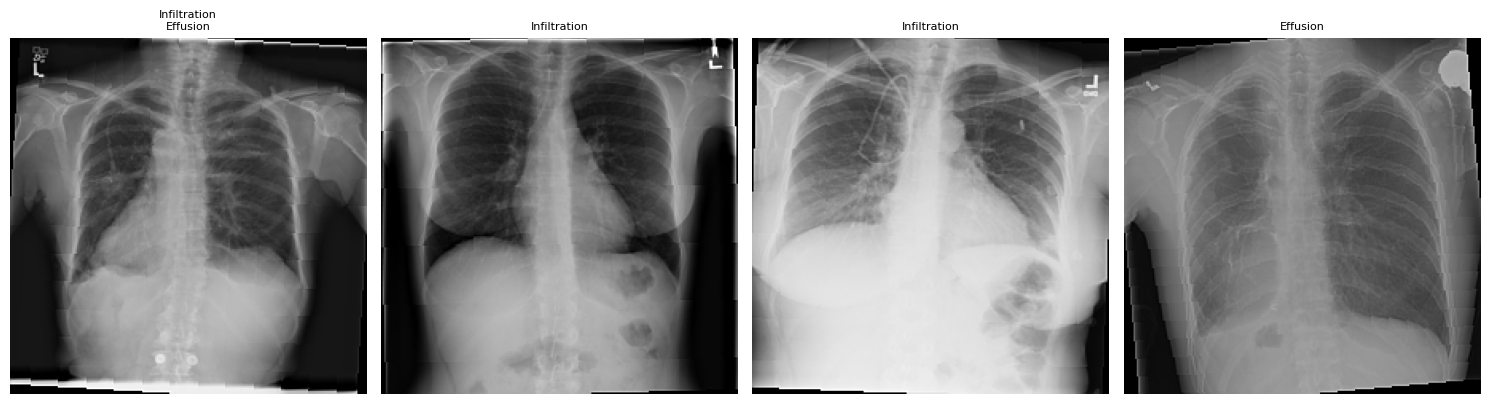

In [72]:

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(images, labels, n=4):
    fig, axes = plt.subplots(1, n, figsize=(15, 4))

    for i in range(n):
        img = denormalize(images[i].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        diseases = [DISEASE_COLUMNS[j] for j in range(14) if labels[i, j] == 1]
        diseases_str = '\n'.join(diseases[:3]) if diseases else 'No Finding'

        axes[i].imshow(img)
        axes[i].set_title(diseases_str, fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizando imágenes de ejemplo...")
show_batch(images, labels, n=4)

In [73]:
len(DISEASE_COLUMNS)

14

## Transfer Learning

In [74]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [76]:
num_classes = len(DISEASE_COLUMNS)

### DenseNet121

In [77]:
from CNNTransformerFusion import CNNTransformerFusion

In [ ]:
num_epochs = 20
train_losses = []
all_outputs = []
all_labels = []

model = CNNTransformerFusion(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, meta, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")

Epoch 1: 100%|██████████| 901/901 [02:24<00:00,  6.24it/s]


Epoch 1 - Loss: 0.2706


Epoch 2:  94%|█████████▍| 850/901 [02:17<00:08,  6.26it/s]

#### Optimizador

#### Entrenamiento

Epoch 1/5: 100%|██████████| 901/901 [1:51:42<00:00,  7.44s/it]


Epoch [1/5] - Loss: 0.3007


Epoch 2/5: 100%|██████████| 901/901 [12:04<00:00,  1.24it/s]


Epoch [2/5] - Loss: 0.2845


Epoch 3/5: 100%|██████████| 901/901 [12:01<00:00,  1.25it/s]


Epoch [3/5] - Loss: 0.2812


Epoch 4/5: 100%|██████████| 901/901 [12:05<00:00,  1.24it/s]


Epoch [4/5] - Loss: 0.2790


Epoch 5/5: 100%|██████████| 901/901 [12:07<00:00,  1.24it/s]

Epoch [5/5] - Loss: 0.2773


#### Evaluacion DenseNet121

In [79]:
model.eval()
total_loss = 0.0
all_outputs = []
all_labels = []

with torch.no_grad():
    for images, meta, labels in tqdm(test_loader, desc="Evaluando"):
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        
        # Recopilar outputs y labels para AUC
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todos los outputs y labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Test Loss: {total_loss / len(test_loader.dataset):.4f}")

Evaluando: 100%|██████████| 492/492 [01:11<00:00,  6.88it/s]

Test Loss: 0.2818


#### Evaluación AUC

In [80]:
try:
    auc_scores = []
    for i in range(num_classes):
        if np.sum(all_labels[:, i]) > 0:
            # Aplicar sigmoid para convertir logits a probabilidades
            probs = 1 / (1 + np.exp(-all_outputs[:, i]))
            auc = roc_auc_score(all_labels[:, i], probs)
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    mean_auc = np.nanmean(auc_scores)
    print(f"\nAUC promedio: {mean_auc:.4f}")
    print("AUC por clase:", np.round(auc_scores, 3))
except Exception as e:
    print("Error al calcular AUC:", e)


AUC promedio: 0.7697
AUC por clase: [0.735 0.678 0.672 0.836 0.811 0.874 0.795 0.79  0.662 0.724 0.882 0.744
 0.801 0.77 ]
